In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import xgboost as xgb
xgb.__version__

'0.7.post3'

In [31]:
df=pd.read_csv('dataset/table_2_f99.csv') # 載入資料

In [32]:
df.head(3)

,user,time_stamp,adgroup_id,pid,clk,cate_id,campaign_id,customer,price,cms_segid,...,buy_1,pv_2,cart_2,fav_2,buy_2,pv_3,cart_3,fav_3,buy_3,brand_New
0,1000027,1494494716,246645,430548_1007,0,6208,195222,199819,62.0,0,...,0,0,0,0,0,0,0,0,0,442562
1,1000027,1494368981,206359,430548_1007,0,6208,157711,180976,63.0,0,...,0,0,0,0,0,0,0,0,0,437825
2,1000033,1494040741,693435,430548_1007,0,4280,144854,126331,39.0,0,...,0,54,3,1,0,97,3,0,0,146115


In [33]:
df.shape

(26557961, 31)

In [34]:
df.columns

Index(['user', 'time_stamp', 'adgroup_id', 'pid', 'clk', 'cate_id',
       'campaign_id', 'customer', 'price', 'cms_segid', 'cms_group_id',
       'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level',
       'occupation', 'new_user_class_level', 'user_cate', 'pv_1', 'cart_1',
       'fav_1', 'buy_1', 'pv_2', 'cart_2', 'fav_2', 'buy_2', 'pv_3', 'cart_3',
       'fav_3', 'buy_3', 'brand_New'],
      dtype='object')

In [36]:
df = df.drop(columns=['user_cate'])

In [37]:
# 除了最後一欄位是目標，其餘欄位皆為用來預測目標的特徵
target=df['clk']
x=df.drop(columns=['clk'])

In [38]:
# 以pd.factorize()方法，將類別資料編碼為dummy code
dataEncoded=pd.DataFrame()
encInfo={}
for col in x.columns:
    facorized=pd.factorize(x[col])

    dataEncoded[col]=facorized[0]
    encInfo[col]=facorized[1]

In [39]:
# 以scikit-learn內建的train, test split, 將資料分成70%訓練，30%測試
trainX,testX,trainY,testY=train_test_split(dataEncoded,target,
                                           test_size=0.3)

In [40]:
# 確認一下資料形狀
print('size of the train data (x):\t',trainX.shape)
print('size of the train data (x):\t',trainY.shape)
print('size of the test data (y):\t',testX.shape)
print('size of the test data (y):\t',testY.shape)

size of the train data (x):	 (18590572, 29)
size of the train data (x):	 (18590572,)
size of the test data (y):	 (7967389, 29)
size of the test data (y):	 (7967389,)


In [41]:
# 將資料存成xgboost要求的型態
data_train = xgb.DMatrix( trainX, label=trainY)
data_test  = xgb.DMatrix( testX, label=testY)

### 2. 訓練資料

In [42]:
%%time

#給予模型參數，告知演算法該如何訓練模型
param = {}
param['objective'] = 'reg:linear' # 做線性回歸
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=10
eval_list  = [(data_train,'train'),(data_test,'test')]
num_round = 50
eval_history={}

# 訓練模型
model = xgb.train( param, data_train, num_round,eval_list,
                  evals_result=eval_history,verbose_eval=False)

CPU times: user 1h 28min 33s, sys: 7min 44s, total: 1h 36min 18s
Wall time: 4min


In [43]:
rmse_train=eval_history['train']['rmse']
rmse_test=eval_history['test']['rmse']

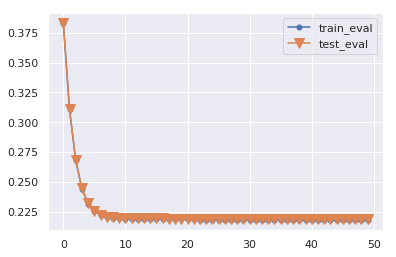

In [44]:
plt.plot(rmse_train,ms=10,marker='.',label='train_eval')
plt.plot(rmse_test,ms=10,marker='v',label='test_eval')
plt.legend()
plt.show()

In [45]:
# 檢視最後rms error
model.eval(data_test)

'[0]\teval-rmse:0.219172'

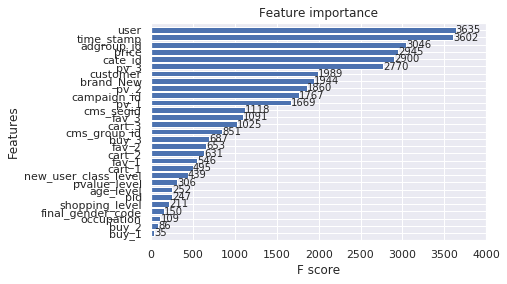

In [63]:
from xgboost import plot_importance
plt = plot_importance(model,height=0.8)
plt

R2

In [61]:
from sklearn.metrics import r2_score
testY_pred=model.predict(data_test)
r2_score(testY, testY_pred)

0.01635284003932269

In [62]:
trainY_pred = model.predict(data_train)
r2_score(trainY, trainY_pred)

0.02828204261060674